In [1]:
# This file contains the complete, recommended structure for your NLP analysis
# and keyword extraction pipeline, organized into executable cells for a Jupyter Notebook.

# ==============================================================================
# Cell 1: Imports, NLTK Download, and Configuration
# ==============================================================================

import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display # Necessary for 'display' to work in a notebook environment

# Set up visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Add project root to path (necessary if config.py is one level up)
# This may need adjustment based on your file structure
try:
    # Assuming the notebook is in a subdirectory (e.g., 'notebooks')
    sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
    from config import DATA_PATHS, BANK_NAMES, APP_IDS
    print("Successfully imported configuration from config.py.")
except ImportError:
    print("Warning: Could not import config.py. Using default paths/names.")
    DATA_PATHS = {
        'processed_reviews': 'data/processed/reviews_processed.csv',
        'sentiment_results': 'data/processed/reviews_with_sentiment.csv'
    }
    BANK_NAMES = {'CBE': 'Commercial Bank of Ethiopia', 'BOA': 'Bank of Abyssinia', 'Dash': 'Dashen Bank'}

# Download VADER lexicon (Run this once)
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
    print("VADER lexicon already downloaded.")
except nltk.downloader.DownloadError:
    print("Downloading VADER lexicon...")
    nltk.download('vader_lexicon')

# Initialize VADER Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

print("Setup Complete. Ready for analysis.")

Successfully imported configuration from config.py.
VADER lexicon already downloaded.
Setup Complete. Ready for analysis.


In [2]:
# ==============================================================================
# Cell 2: Load Data
# ==============================================================================

# Define the path to your clean data
INPUT_FILE = DATA_PATHS['processed_reviews']

try:
    df = pd.read_csv(INPUT_FILE)
    df['review'] = df['review'].astype(str).fillna('') # Ensure reviews are strings
    # Convert 'bank' names from acronyms to full names if necessary (only run if your CSV stores acronyms)
    # df['bank'] = df['bank'].map(BANK_NAMES) 
    print(f"Successfully loaded {len(df)} reviews from {INPUT_FILE}")
    print("\nSample Data:")
    display(df.head(3))
except FileNotFoundError:
    print(f"ERROR: File not found at {INPUT_FILE}. Please ensure Task 1 completed correctly.")
    # Exit or create a dummy DataFrame to prevent errors in later cells
    df = pd.DataFrame(columns=['bank', 'review', 'rating', 'date', 'source'])

Successfully loaded 1515 reviews from data/processed/reviews_processed.csv

Sample Data:


,review,rating,date,bank,source
0,good,5,2025-11-30,Commercial Bank of Ethiopia,Google Play Store
1,cbe ይለያል።,5,2025-11-29,Commercial Bank of Ethiopia,Google Play Store
2,it's special for me,5,2025-11-29,Commercial Bank of Ethiopia,Google Play Store


In [3]:
# ==============================================================================
# Cell 3: Sentiment Analysis (VADER)
# ==============================================================================

# 1. Define score calculation and classification functions
def get_vader_score(text):
    """Returns the VADER compound sentiment score."""
    return sia.polarity_scores(text)['compound']

def classify_sentiment(score):
    """Classifies the sentiment based on the compound score thresholds."""
    # Standard VADER thresholds
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# 2. Apply functions to the DataFrame
if not df.empty:
    df['sentiment_score'] = df['review'].apply(get_vader_score)
    df['sentiment_label'] = df['sentiment_score'].apply(classify_sentiment)

    print("Sentiment scores and labels added.")

    # Display the distribution
    print("\nSentiment Label Distribution:")
    print(df['sentiment_label'].value_counts())

# Display the enriched data sample
    display(df[['bank', 'review', 'sentiment_score', 'sentiment_label']].head())
else:
    print("Cannot perform sentiment analysis: DataFrame is empty.")

Sentiment scores and labels added.

Sentiment Label Distribution:
sentiment_label
Positive    779
Neutral     506
Negative    230
Name: count, dtype: int64


,bank,review,sentiment_score,sentiment_label
0,Commercial Bank of Ethiopia,good,0.4404,Positive
1,Commercial Bank of Ethiopia,cbe ይለያል።,0.0000,Neutral
2,Commercial Bank of Ethiopia,it's special for me,0.4019,Positive
3,Commercial Bank of Ethiopia,make it user friendly.,0.4939,Positive
4,Commercial Bank of Ethiopia,maaliif daddafee install gaafata,0.0000,Neutral


In [4]:
# ==============================================================================
# Cell 4: Sentiment Aggregation by Bank and Rating
# ==============================================================================

if not df.empty:
    print("Aggregating Results...")

    # 1. Overall Mean Sentiment per Bank
    overall_sentiment = df.groupby('bank')['sentiment_score'].mean().sort_values(ascending=False)
    print("\n--- Overall Mean Sentiment Score Per Bank (Higher is better) ---")
    display(overall_sentiment.to_frame().round(3))

    # 2. Mean Sentiment Score by Bank and Star Rating
    # Use 'pivot_table' as a robust alternative to 'groupby' for this structure
    rating_sentiment = df.pivot_table(index='rating', columns='bank', values='sentiment_score', aggfunc='mean')
    print("\n--- Mean Sentiment Score by Star Rating (1 to 5) ---")
    display(rating_sentiment.round(3))

    # 3. Sentiment Label Count per Bank
    sentiment_count = df.groupby(['bank', 'sentiment_label']).size().unstack(fill_value=0)
    # Reorder columns for a standard P/N/Neutral view
    sentiment_count = sentiment_count.reindex(columns=['Positive', 'Neutral', 'Negative'], fill_value=0)
    print("\n--- Sentiment Label Counts Per Bank ---")
    display(sentiment_count)
else:
    print("Cannot perform aggregation: DataFrame is empty.")

Aggregating Results...

--- Overall Mean Sentiment Score Per Bank (Higher is better) ---


,sentiment_score
bank,
Dashen Bank,0.368
Commercial Bank of Ethiopia,0.235
Bank of Abyssinia,0.062



--- Mean Sentiment Score by Star Rating (1 to 5) ---


bank,Bank of Abyssinia,Commercial Bank of Ethiopia,Dashen Bank
rating,,,
1,-0.174,-0.088,-0.119
2,0.024,0.091,-0.017
3,0.107,0.102,0.219
4,0.325,0.291,0.369
5,0.292,0.336,0.512



--- Sentiment Label Counts Per Bank ---


sentiment_label,Positive,Neutral,Negative
bank,,,
Bank of Abyssinia,193,193,130
Commercial Bank of Ethiopia,246,187,44
Dashen Bank,340,126,56


In [5]:
# ==============================================================================
# Cell 5: TF-IDF Keyword Extraction
# ==============================================================================

def extract_keywords_by_bank(df, bank_name, n_features=20):
    """Filters data, applies TF-IDF, and returns top N keywords/n-grams."""
    
    # 1. Filter reviews for the current bank
    bank_df = df[df['bank'] == bank_name]
    
    # 2. Initialize TF-IDF Vectorizer
    # Ngram_range=(1, 2) looks for single words and two-word phrases
    # max_df=0.85 removes terms that are too common (e.g., in >85% of documents)
    vectorizer = TfidfVectorizer(
        stop_words='english',
        ngram_range=(1, 2), 
        max_df=0.85
    )
    
    # 3. Fit and Transform
    try:
        # Check if there are enough documents (reviews) to perform TF-IDF
        if len(bank_df) < 2:
            return [f"Only {len(bank_df)} reviews. Not enough data to run TF-IDF for {bank_name}"]

        tfidf_matrix = vectorizer.fit_transform(bank_df['review'])
    except ValueError as e:
        return [f"TF-IDF Error for {bank_name}: {e}"]

    feature_names = vectorizer.get_feature_names_out()
    
    # 4. Get top features by summing their scores
    # .A1 flattens the matrix sum into a 1D array
    tfidf_sums = tfidf_matrix.sum(axis=0).A1
    keywords = pd.Series(tfidf_sums, index=feature_names).sort_values(ascending=False)
    
    return keywords.head(n_features).index.tolist()

# Run extraction for all banks
if not df.empty:
    bank_keywords = {}
    
    # Use the full bank names from the DataFrame for iteration
    # Assuming 'bank' column contains the full names after Cell 2 (or a similar transformation)
    unique_banks = df['bank'].unique()

    print("\n--- Starting Keyword Extraction ---")
    for bank_name in unique_banks:
        keywords = extract_keywords_by_bank(df, bank_name)
        bank_keywords[bank_name] = keywords
        
        print(f"\n--- Top 20 Keywords for {bank_name} ---")
        # Print the list cleanly
        for i, keyword in enumerate(keywords):
            print(f"{i+1}. {keyword}")
else:
    print("Cannot extract keywords: DataFrame is empty.")


--- Starting Keyword Extraction ---

--- Top 20 Keywords for Commercial Bank of Ethiopia ---
1. good
2. app
3. best
4. nice
5. cbe
6. bank
7. good app
8. like
9. excellent
10. application
11. best app
12. love
13. use
14. nice app
15. apps
16. banking
17. great
18. mobile
19. update
20. thank

--- Top 20 Keywords for Bank of Abyssinia ---
1. app
2. good
3. best
4. working
5. work
6. boa
7. bank
8. worst
9. doesn
10. banking
11. great
12. nice
13. like
14. mobile
15. use
16. doesn work
17. bad
18. fast
19. application
20. worst app

--- Top 20 Keywords for Dashen Bank ---
1. app
2. best
3. good
4. bank
5. dashen
6. super
7. nice
8. fast
9. amazing
10. banking
11. easy
12. dashen bank
13. super app
14. use
15. best app
16. slow
17. great
18. application
19. like
20. nice app



--- Generating Visualizations ---


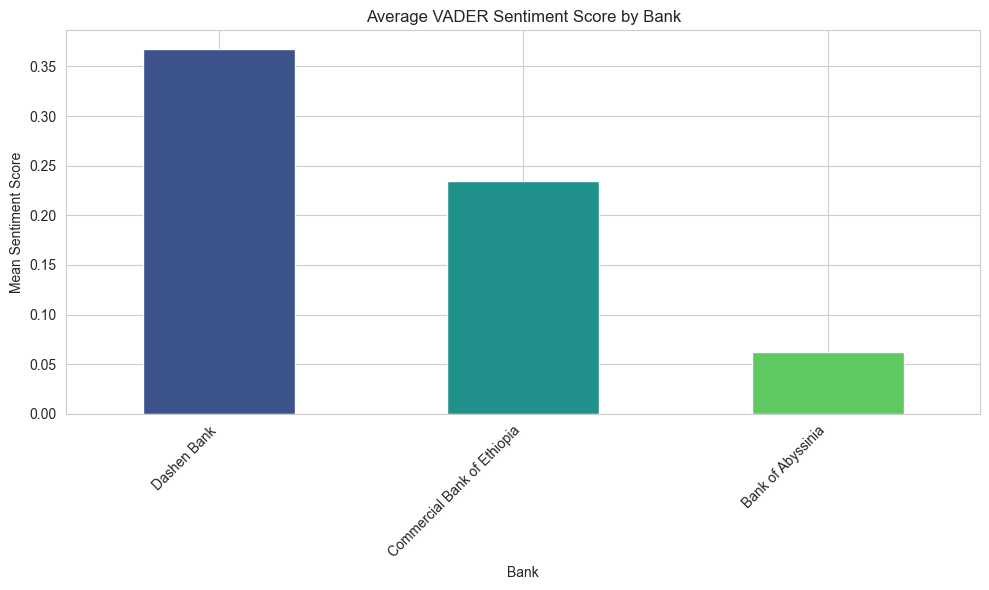

<Figure size 1000x600 with 0 Axes>

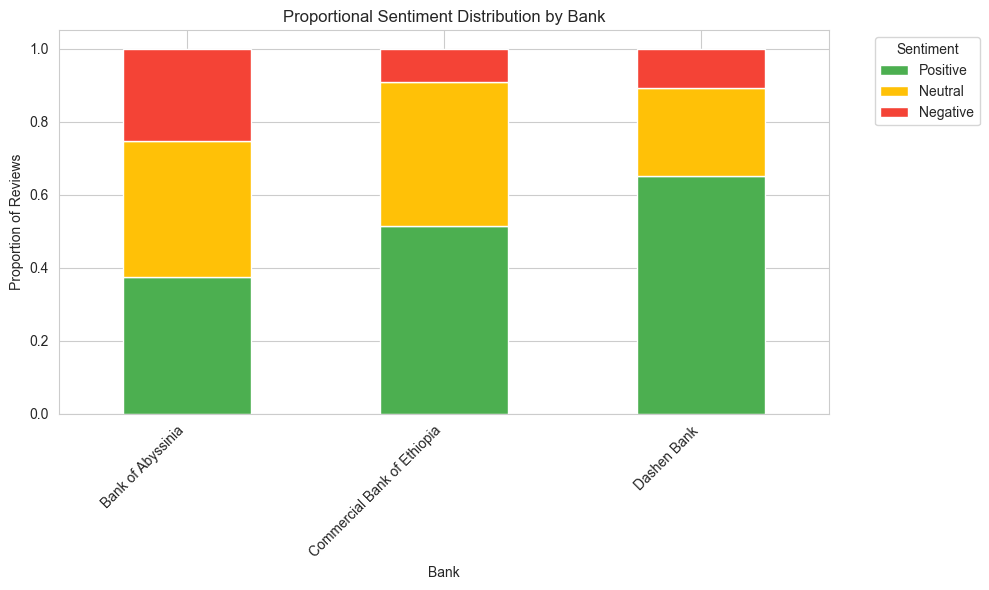

Visualizations complete.


In [6]:
# ==============================================================================
# Cell 6: Visualization (NEW CELL)
# ==============================================================================

if not df.empty:
    print("\n--- Generating Visualizations ---")

# 1. Bar plot for Overall Mean Sentiment Score per Bank
    plt.figure(figsize=(10, 6))
    overall_sentiment.plot(kind='bar', color=sns.color_palette("viridis", len(overall_sentiment)))
    plt.title('Average VADER Sentiment Score by Bank')
    plt.ylabel('Mean Sentiment Score')
    plt.xlabel('Bank')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # 2. Stacked Bar Chart for Sentiment Label Distribution
    # Use the 'sentiment_count' DataFrame generated in Cell 4
    if 'sentiment_count' in locals():
        sentiment_count_norm = sentiment_count.apply(lambda x: x / x.sum(), axis=1) # Normalize to 100%
        
        plt.figure(figsize=(10, 6))
        sentiment_count_norm.plot(kind='bar', stacked=True, color=['#4CAF50', '#FFC107', '#F44336']) # Green, Yellow, Red
        plt.title('Proportional Sentiment Distribution by Bank')
        plt.ylabel('Proportion of Reviews')
        plt.xlabel('Bank')
        plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        print("Visualizations complete.")
    else:
        print("Skipping visualizations: Aggregated data not available (Cell 4 likely failed or was skipped).")

In [7]:
# ==============================================================================
# Cell 7: Save Final Enriched Data (FIXED)
# ==============================================================================

if not df.empty and 'sentiment_score' in df.columns:
    # 1. Map DataFrame columns to the required database column names
    # Note: If your preprocessing or scraping used the full bank name, you'll need
    # to ensure the 'bank' column is renamed to 'bank_code' (e.g., 'CBE', 'BOA') 
    # for the database script to work. Assuming 'bank' contains the full name here.
    
    # We will rename the columns in the DataFrame for the final output
    df_final = df.rename(columns={
        'bank': 'bank_code', 
        'review': 'review_text', 
        'date': 'review_date'
    })
    
    # Define the final columns required by the PostgreSQL script
    final_cols = ['bank_code', 'review_text', 'rating', 'review_date', 'sentiment_label', 'sentiment_score']

    # Use the correct path for the final CSV required by db_operations.py
    OUTPUT_FILE = DATA_PATHS['final_results'] # <--- POINTS TO reviews_final.csv

    # Ensure all required columns exist before attempting to save
    missing_cols = [col for col in final_cols if col not in df_final.columns]
    if missing_cols:
        print(f"ERROR: Cannot save. Missing columns: {missing_cols}")
        print("Please check previous cells for expected columns like 'bank_code'.")
    else:
        # Save the final, correctly formatted and named CSV
        df_final[final_cols].to_csv(OUTPUT_FILE, index=False)
        print(f"\n✓ Final enriched data saved successfully to: {OUTPUT_FILE}")
        print("The file reviews_final.csv is now ready for Phase 3.")
else:
    print("Cannot save data: DataFrame is empty or sentiment analysis failed.")


✓ Final enriched data saved successfully to: data/processed/reviews_final.csv
The file reviews_final.csv is now ready for Phase 3.
